In [29]:
!pip install pandas -q
!pip install yfinance -q
!pip install matplotlib -q
!pip install seaborn - q
!pip install scipy -q
!pip install lxml


ERROR: Invalid requirement: '-': Expected package name at the start of dependency specifier
    -
    ^


   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/3.8 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 15.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


In [31]:

def get_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)
    df = table[0]
    tickers = df['Symbol'].tolist()
    return tickers

C:\Users\Gokay\AppData\Local\Temp\ipykernel_20004\3495862594.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-01 -> 2025-06-01)')
['ABT']: Timeout('Failed to perform, curl: (28) Operation timed out after 10005 milliseconds with 33795 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
C:\Users\Gokay\AppData\Local\Temp\ipykernel_20004\3495862594.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(annual_std_dev[i], a

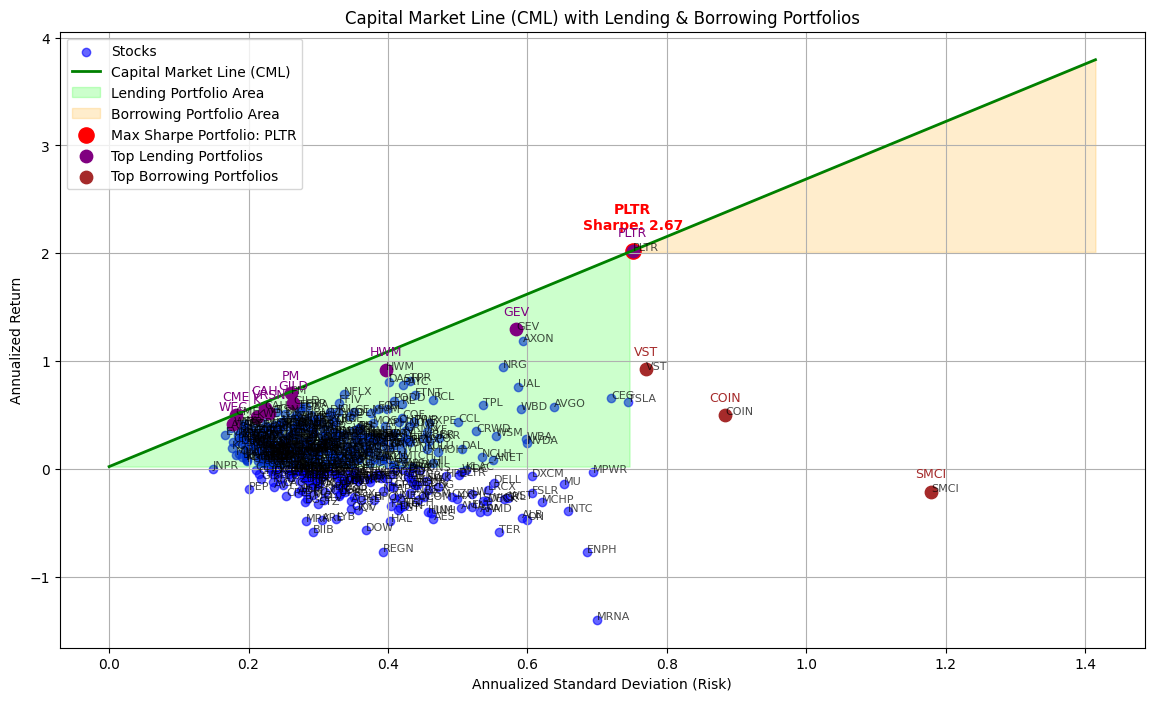

CML'a teğet geçen (Max Sharpe) portföy: PLTR Sharpe: 2.67

Lending Portföyleri (Risk < Max Sharpe):
1. PLTR - Sharpe: 2.67
2. CME - Sharpe: 2.66
3. PM - Sharpe: 2.61
4. CAH - Sharpe: 2.43
5. HWM - Sharpe: 2.26
6. GILD - Sharpe: 2.23
7. WEC - Sharpe: 2.21
8. GEV - Sharpe: 2.19
9. VRSN - Sharpe: 2.18
10. K - Sharpe: 2.15

Borrowing Portföyleri (Risk > Max Sharpe):
1. VST - Sharpe: 1.18
2. COIN - Sharpe: 0.54
3. SMCI - Sharpe: -0.20


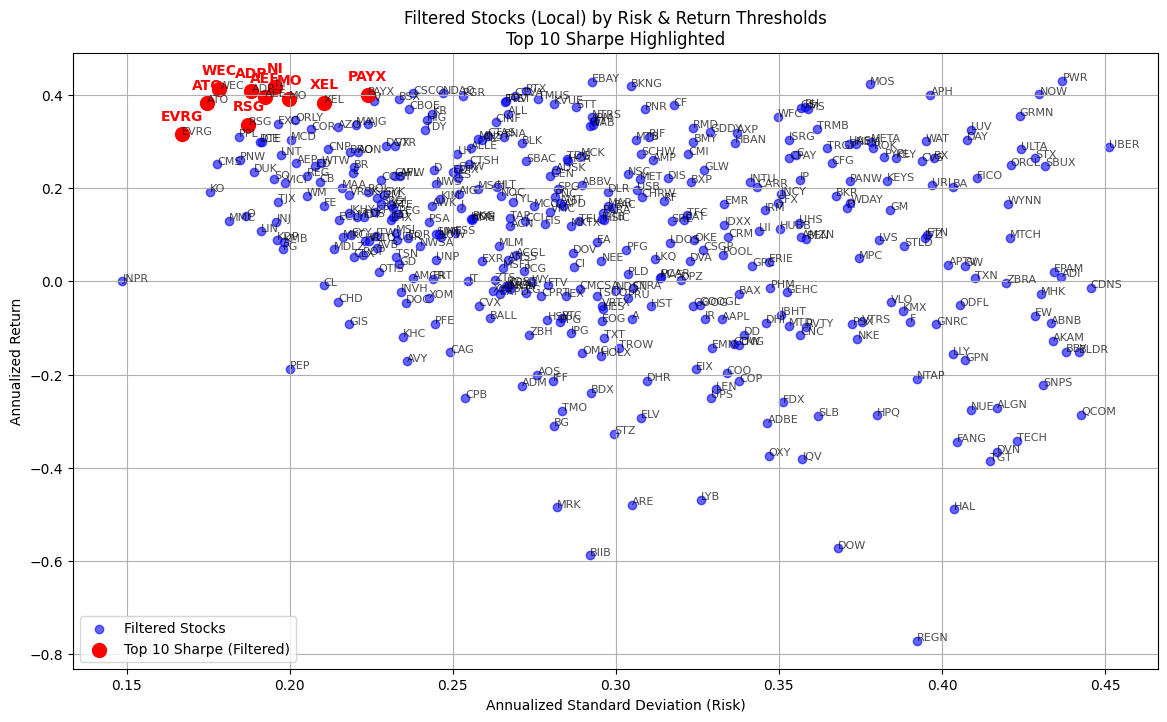

Risk threshold: 0.4515, Return threshold: 0.4309
Filtered Top 10 Sharpe oranına sahip hisseler:
1. WEC - Sharpe: 2.21
2. ATO - Sharpe: 2.08
3. ADP - Sharpe: 2.06
4. NI - Sharpe: 2.03
5. AEE - Sharpe: 1.96
6. MO - Sharpe: 1.86
7. EVRG - Sharpe: 1.77
8. XEL - Sharpe: 1.72
9. PAYX - Sharpe: 1.70
10. RSG - Sharpe: 1.68


In [23]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import os

def get_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)
    df = table[0]
    tickers = df['Symbol'].tolist()
    return tickers

def fetch_data(tickers, start, end, csv_path="data.csv"):
    # Eğer CSV dosyası varsa oradan oku
    if os.path.exists(csv_path):
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
        # Sadece istenen tarih aralığını ve hisseleri al
        data = data.loc[(data.index >= start) & (data.index <= end), :]
        data = data[[col for col in data.columns if col in tickers]]
        valid_tickers = data.columns.tolist()
        return data, valid_tickers
    # Yoksa Yahoo'dan indir ve kaydet
    data = yf.download(tickers, start=start, end=end)['Close']
    data = data.dropna(axis=1, how='all')
    data.to_csv(csv_path)
    valid_tickers = data.columns.tolist()
    return data, valid_tickers


def calculate_annualized_returns_and_risk(data):
    returns = data.pct_change().dropna()
    mean_daily_returns = returns.mean()
    std_daily_returns = returns.std()
    trading_days = 252
    annual_returns = mean_daily_returns * trading_days
    annual_std_dev = std_daily_returns * np.sqrt(trading_days)
    return annual_returns, annual_std_dev

def plot_cml_and_portfolios(annual_std_dev, annual_returns, tickers, risk_free_rate=0.02, top_n=10):
    # Sharpe oranı hesapla
    sharpe_ratios = (annual_returns - risk_free_rate) / annual_std_dev
    max_sharpe_idx = sharpe_ratios.idxmax()
    max_sharpe_return = annual_returns[max_sharpe_idx]
    max_sharpe_risk = annual_std_dev[max_sharpe_idx]

    # Capital Market Line (CML)
    cml_x = np.linspace(0, max(annual_std_dev)*1.2, 200)
    cml_y = risk_free_rate + (max_sharpe_return - risk_free_rate) / max_sharpe_risk * cml_x

    # Lending (CML üzeri, risksiz faiz ile max Sharpe arası)
    lending_mask = (cml_x >= 0) & (cml_x <= max_sharpe_risk)
    # Borrowing (CML üzeri, max Sharpe sonrası)
    borrowing_mask = (cml_x > max_sharpe_risk)

    # En uygun Lending portföyleri (Sharpe'a göre, risk < max_sharpe_risk)
    lending_candidates = sharpe_ratios[annual_std_dev <= max_sharpe_risk].sort_values(ascending=False).head(top_n)
    # En uygun Borrowing portföyleri (Sharpe'a göre, risk > max_sharpe_risk)
    borrowing_candidates = sharpe_ratios[annual_std_dev > max_sharpe_risk].sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(14,8))
    # Hisseleri çiz
    plt.scatter(annual_std_dev, annual_returns, c='blue', alpha=0.6, label='Stocks')
    for i, ticker in enumerate(tickers):
        plt.text(annual_std_dev[i], annual_returns[i], ticker, fontsize=8, alpha=0.7)

    # CML çiz
    plt.plot(cml_x, cml_y, color='green', linestyle='-', linewidth=2, label='Capital Market Line (CML)')

    # Lending bölgesi (taralı)
    plt.fill_between(cml_x[lending_mask], cml_y[lending_mask], risk_free_rate, color='lime', alpha=0.2, label='Lending Portfolio Area')
    # Borrowing bölgesi (taralı)
    plt.fill_between(cml_x[borrowing_mask], cml_y[borrowing_mask], cml_y[lending_mask][-1], color='orange', alpha=0.2, label='Borrowing Portfolio Area')

    # CML'a teğet geçen hisseyi işaretle
    plt.scatter([max_sharpe_risk], [max_sharpe_return], color='red', s=120, label=f'Max Sharpe Portfolio: {max_sharpe_idx}')
    plt.annotate(f'{max_sharpe_idx}\nSharpe: {sharpe_ratios[max_sharpe_idx]:.2f}',
                 (max_sharpe_risk, max_sharpe_return), textcoords="offset points", xytext=(0,15),
                 ha='center', color='red', fontsize=10, fontweight='bold')

    # Lending portföylerini işaretle
    plt.scatter(annual_std_dev[lending_candidates.index], annual_returns[lending_candidates.index], 
                c='purple', s=80, label='Top Lending Portfolios')
    for ticker in lending_candidates.index:
        plt.annotate(ticker, (annual_std_dev[ticker], annual_returns[ticker]), 
                     textcoords="offset points", xytext=(0,10), ha='center', color='purple', fontsize=9)

    # Borrowing portföylerini işaretle
    plt.scatter(annual_std_dev[borrowing_candidates.index], annual_returns[borrowing_candidates.index], 
                c='brown', s=80, label='Top Borrowing Portfolios')
    for ticker in borrowing_candidates.index:
        plt.annotate(ticker, (annual_std_dev[ticker], annual_returns[ticker]), 
                     textcoords="offset points", xytext=(0,10), ha='center', color='brown', fontsize=9)

    plt.xlabel('Annualized Standard Deviation (Risk)')
    plt.ylabel('Annualized Return')
    plt.title('Capital Market Line (CML) with Lending & Borrowing Portfolios')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("CML'a teğet geçen (Max Sharpe) portföy:", max_sharpe_idx, f"Sharpe: {sharpe_ratios[max_sharpe_idx]:.2f}")
    print("\nLending Portföyleri (Risk < Max Sharpe):")
    for i, ticker in enumerate(lending_candidates.index, 1):
        print(f"{i}. {ticker} - Sharpe: {sharpe_ratios[ticker]:.2f}")
    print("\nBorrowing Portföyleri (Risk > Max Sharpe):")
    for i, ticker in enumerate(borrowing_candidates.index, 1):
        print(f"{i}. {ticker} - Sharpe: {sharpe_ratios[ticker]:.2f}")

def filter_and_plot_local_portfolios(annual_std_dev, annual_returns, tickers, risk_free_rate=0.02):
    # Eşik değerleri hesapla
    risk_threshold = annual_std_dev.mean() + annual_std_dev.std()
    return_threshold = annual_returns.mean() + annual_returns.std()

    # Eşiklere göre filtrele
    mask = (annual_std_dev <= risk_threshold) & (annual_returns <= return_threshold)
    filtered_std = annual_std_dev[mask]
    filtered_ret = annual_returns[mask]
    filtered_tickers = filtered_std.index.tolist()

    # Sharpe oranı hesapla
    sharpe_ratios = (filtered_ret - risk_free_rate) / filtered_std

    # En yüksek 10 Sharpe oranlı hisseyi bul
    top10_idx = sharpe_ratios.sort_values(ascending=False).head(10).index
    top10_std = filtered_std[top10_idx]
    top10_ret = filtered_ret[top10_idx]

    # Grafik çizimi
    plt.figure(figsize=(14,8))
    plt.scatter(filtered_std, filtered_ret, c='blue', alpha=0.6, label='Filtered Stocks')
    plt.scatter(top10_std, top10_ret, c='red', s=100, label='Top 10 Sharpe (Filtered)')
    for ticker in filtered_tickers:
        plt.text(filtered_std[ticker], filtered_ret[ticker], ticker, fontsize=8, alpha=0.7)
    for ticker in top10_idx:
        plt.annotate(ticker, (filtered_std[ticker], filtered_ret[ticker]), 
                     textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=10, fontweight='bold')
    plt.xlabel('Annualized Standard Deviation (Risk)')
    plt.ylabel('Annualized Return')
    plt.title('Filtered Stocks (Local) by Risk & Return Thresholds\nTop 10 Sharpe Highlighted')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Risk threshold: {risk_threshold:.4f}, Return threshold: {return_threshold:.4f}")
    print("Filtered Top 10 Sharpe oranına sahip hisseler:")
    for i, ticker in enumerate(top10_idx, 1):
        print(f"{i}. {ticker} - Sharpe: {sharpe_ratios[ticker]:.2f}")

# Ana fonksiyonda çağırmak için:
def main():
    tickers = get_tickers()
    data, valid_tickers = fetch_data(tickers, start='2020-06-01', end='2025-06-01', csv_path="data.csv")
    annual_returns, annual_std_dev = calculate_annualized_returns_and_risk(data)
    plot_cml_and_portfolios(annual_std_dev, annual_returns, valid_tickers, risk_free_rate=0.02, top_n=10)
    filter_and_plot_local_portfolios(annual_std_dev, annual_returns, valid_tickers, risk_free_rate=0.02)

if __name__ == "__main__":
    main()

In [ ]:
import requests

def get_news_yahoo(ticker, count=10):
    """
    Yahoo Finance üzerinden ilgili hisse için son haberleri getirir.
    """
    url = f"https://query1.finance.yahoo.com/v1/finance/search?q={ticker}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"HTTP hata kodu: {response.status_code}")
            return []
        try:
            data = response.json()
        except Exception as e:
            print(f"Yanıt JSON'a çevrilemedi: {e}")
            return []
        news_list = []
        if "news" in data:
            for news in data["news"][:count]:
                news_list.append({
                    "title": news.get("title"),
                    "publisher": news.get("publisher"),
                    "link": news.get("link"),
                    "providerPublishTime": news.get("providerPublishTime")
                })
        return news_list
    except Exception as e:
        print(f"Haber alınırken hata oluştu: {e}")
        return []

In [24]:
haberler = get_news_yahoo(["AAPL"], count=1)
for haber in haberler:
    print(haber["title"], "-", haber["publisher"])

HTTP hata kodu: 429
